<a href="https://colab.research.google.com/github/jasdeepbajaj/Image_Captioning/blob/main/Image_Captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [96]:
import os
import sys
from pycocotools.coco import COCO
import urllib
import zipfile

import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
nltk.download('punkt')

import torch
import torch.utils.data as data
from PIL import Image
import numpy as np
from tqdm import tqdm
import random
import json
import pickle
from collections import Counter

from torchvision import transforms

import torch.utils.data as data

import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import ResNet50_Weights

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
os.makedirs('opt' , exist_ok=True)
os.chdir( '/content/opt' )
!git clone 'https://github.com/cocodataset/cocoapi.git'

Cloning into 'cocoapi'...
remote: Enumerating objects: 975, done.
remote: Total 975 (delta 0), reused 0 (delta 0), pack-reused 975
Receiving objects: 100% (975/975), 11.72 MiB | 24.70 MiB/s, done.
Resolving deltas: 100% (576/576), done.


In [4]:
os.chdir('/content/opt/cocoapi')

# Download the annotation :
annotations_trainval2014 = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip'
image_info_test2014 = 'http://images.cocodataset.org/annotations/image_info_test2014.zip'

urllib.request.urlretrieve(annotations_trainval2014 , filename = 'annotations_trainval2014.zip' )
urllib.request.urlretrieve(image_info_test2014 , filename= 'image_info_test2014.zip' )

('image_info_test2014.zip', <http.client.HTTPMessage at 0x7b157e92a800>)

In [5]:
with zipfile.ZipFile('annotations_trainval2014.zip' , 'r') as zip_ref:
  zip_ref.extractall( '/content/opt/cocoapi'  )

try:
  os.remove( 'annotations_trainval2014.zip' )
  print('zip removed')
except:
  None

with zipfile.ZipFile('image_info_test2014.zip' , 'r') as zip_ref:
  zip_ref.extractall( '/content/opt/cocoapi'  )

try:
  os.remove( 'image_info_test2014.zip' )
  print('zip removed')
except:
  None

zip removed
zip removed


In [6]:
dataDir = '/content/opt/cocoapi'
dataType = 'val2014'
instances_annFile = os.path.join(dataDir, 'annotations/instances_{}.json'.format(dataType))
coco = COCO(instances_annFile)

captions_annFile = os.path.join(dataDir, 'annotations/captions_{}.json'.format(dataType))
coco_caps = COCO(captions_annFile)

ids = list(coco.anns.keys())

loading annotations into memory...
Done (t=6.72s)
creating index...
index created!
loading annotations into memory...
Done (t=0.41s)
creating index...
index created!


http://images.cocodataset.org/val2014/COCO_val2014_000000505831.jpg


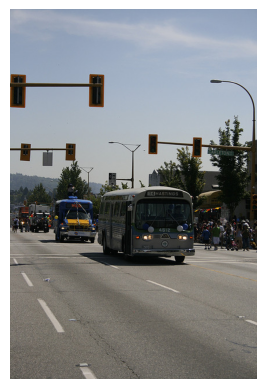

A bus driving down a city street during the day.
Traffic on a street with a bus going through an intersection.
a line of autos traveling down city street 
A bus drives down a lane of a city street.
Buses going through several intersections with their headlights on


In [7]:
# pick a random image and obtain the corresponding URL
ann_id = np.random.choice(ids)
img_id = coco.anns[ann_id]['image_id']
img = coco.loadImgs(img_id)[0]
url = img['coco_url']

# print URL and visualize corresponding image
print(url)
I = io.imread(url)
plt.axis('off')
plt.imshow(I)
plt.show()

# load and display captions
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)

In [8]:
os.chdir('/content/opt/cocoapi')

train2014 = 'http://images.cocodataset.org/zips/train2014.zip'
test2014 = 'http://images.cocodataset.org/zips/test2014.zip'
val2014 = 'http://images.cocodataset.org/zips/val2014.zip'

urllib.request.urlretrieve( train2014 , 'train2014' )
urllib.request.urlretrieve( test2014 , 'test2014' )
urllib.request.urlretrieve( val2014 , 'val2014' )

('val2014', <http.client.HTTPMessage at 0x7b166cc12ec0>)

In [9]:
os.chdir('/content/opt/cocoapi')
with zipfile.ZipFile( 'train2014' , 'r' ) as zip_ref:
  zip_ref.extractall( 'images' )

try:
  os.remove( 'train2014' )
  print('zip removed')
except:
  None

os.chdir('/content/opt/cocoapi')
with zipfile.ZipFile( 'val2014' , 'r' ) as zip_ref:
  zip_ref.extractall( 'images' )

try:
  os.remove( 'val2014' )
  print('zip removed')
except:
  None

os.chdir('/content/opt/cocoapi')
with zipfile.ZipFile( 'test2014' , 'r' ) as zip_ref:
  zip_ref.extractall( 'images' )

try:
  os.remove( 'test2014' )
  print('zip removed')
except:
  None

zip removed
zip removed
zip removed


In [51]:
class Vocabulary(object):
  def __init__(self, vocab_threshold, vocab_file="/content/vocab.pkl", start_word = "<start>", end_word = "<end>", unk_word = "<unk>", annotations_file = "/content/opt/cocoapi/annotations/captions_train2014.json", vocab_from_file = False):
    self.vocab_threshold = vocab_threshold
    self.vocab_file = vocab_file
    self.start_word = start_word
    self.end_word = end_word
    self.unk_word = unk_word
    self.annotations_file = annotations_file
    self.vocab_from_file = vocab_from_file
    self.get_vocab()

  def get_vocab(self):
    """Load the vocabulary from file or build the vocabulary from scratch"""
    if os.path.exists(self.vocab_file) and self.vocab_from_file:
      with open(self.vocab_file, 'rb') as f:
        vocab = pickle.load(f)
        self.word2idx = vocab.word2idx
        self.idx2word = vocab.idx2word
      print("Vocabulary Successfully Loaded from vocab.pkl file")

    else:
      self.build_vocab()
      with open(self.vocab_file, 'wb') as f:
        pickle.dump(self, f)
      print("Vocabulary Successfully Saved to vocab.pkl file")

  def build_vocab(self):
    """Populate the dictionaries for converting tokens to integers (and vice-versa)."""
    self.init_vocab()
    self.add_word(self.start_word)
    self.add_word(self.end_word)
    self.add_word(self.unk_word)
    self.add_captions()

  def init_vocab(self):
    """Initialize the dictionaries for converting tokens to integers (and vice-versa)."""
    self.word2idx = {}
    self.idx2word = {}
    self.idx = 0

  def add_word(self, word):
    """Add a token to the vocabulary."""
    if not word in self.word2idx:
      self.word2idx[word] = self.idx
      self.idx2word[self.idx] = word
      self.idx += 1

  def add_captions(self):
    """Loop over training captions and add all tokens to the vocabulary that meet or exceed the threshold."""
    coco = COCO(self.annotations_file)
    counter = Counter()
    ids = coco.anns.keys()
    for i, id in enumerate(ids):
      caption = str(coco.anns[id]['caption'])
      tokens = nltk.tokenize.word_tokenize(caption.lower())
      counter.update(tokens)

      if i% 100000 == 0:
        print("[%d/%d] Tokenizing captions..." % (i, len(ids)))

    words = [word for word, cnt in counter.items() if cnt >= self.vocab_threshold]

    for i, word in enumerate(words):
      self.add_word(word)

  def __call__(self, word):
    if not word in self.word2idx:
      return self.word2idx[self.unk_word]

    return self.word2idx[word]

  def __len__(self):
    return len(self.word2idx)

In [52]:
class CoCoDataset(data.Dataset):
  def __init__(self, transform, mode, batch_size, vocab_threshold, vocab_file, start_word, end_word,
               unk_word, annotations_file, vocab_from_file, img_folder):
    self.transform = transform
    self.mode = mode
    self.batch_size = batch_size
    self.vocab = Vocabulary(vocab_threshold, vocab_file, start_word, end_word, unk_word, annotations_file,
                            vocab_from_file)
    self.img_folder = img_folder
    if self.mode == "train":
      self.coco = COCO(annotations_file)
      self.ids = list(self.coco.anns.keys())
      print("Obtaining Captions lengths...")
      all_tokens = [nltk.tokenize.word_tokenize(str(self.coco.anns[self.ids[index]]['caption']).lower()) for index in tqdm(np.arange(len(self.ids)))]
      self.caption_lengths = [len(token) for token in all_tokens]

    else:
      test_info = json.load(open(annotations_file).read())
      self.paths = [item['file_name'] for item in test_info['images']]

  def __getitem__(self, index):
    if self.mode == "train":
      ann_id = self.ids[index]
      caption = self.coco.anns[ann_id]['caption']
      img_id = self.coco.anns[ann_id]['image_id']
      path = self.coco.loadImgs(img_id)[0]['file_name']

      image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
      image = self.transform(image)

      # Convert caption to tensor of word ids.
      tokens = nltk.tokenize.word_tokenize(str(caption).lower())
      caption = []
      caption.append(self.vocab(self.vocab.start_word))
      caption.extend([self.vocab(token) for token in tokens])
      caption.append(self.vocab(self.vocab.end_word))
      caption = torch.Tensor(caption).long()

      # return pre-processed image and caption tensors
      return image, caption

    else:

      path = self.paths[index]

      # Convert image to tensor and pre-process using transform
      PIL_image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
      orig_image = np.array(PIL_image)
      image = self.transform(PIL_image)

      # return original image and pre-processed image tensor
      return orig_image, image

  def get_train_indices(self):
    sel_length = np.random.choice(self.caption_lengths)
    all_indices = np.where([self.caption_lengths[i] == sel_length for i in np.arange(len(self.caption_lengths))])[0]
    indices = list(np.random.choice(all_indices, size=self.batch_size))
    return indices

  def __len__(self):
    if self.mode == 'train':
        return len(self.ids)
    else:
        return len(self.paths)

In [53]:
def get_loader(transform, mode='train', batch_size=1, vocab_threshold=None, vocab_file='./vocab.pkl', start_word="<start>", end_word="<end>", unk_word="<unk>", vocab_from_file=True, num_workers=0, cocoapi_loc='/content/opt'):
  assert mode in ['train', 'test'], "mode must be one of 'train' or 'test'."
  if vocab_from_file==False: assert mode=='train', "To generate vocab from captions file, must be in training mode (mode='train')."

  if mode == 'train':
    if vocab_from_file==True: assert os.path.exists(vocab_file), "vocab_file does not exist.  Change vocab_from_file to False to create vocab_file."
    img_folder = os.path.join(cocoapi_loc, 'cocoapi/images/train2014/')
    annotations_file = os.path.join(cocoapi_loc, 'cocoapi/annotations/captions_train2014.json')

  if mode == 'test':
    assert batch_size==1, "Please change batch_size to 1 if testing your model."
    assert os.path.exists(vocab_file), "Must first generate vocab.pkl from training data."
    assert vocab_from_file==True, "Change vocab_from_file to True."
    img_folder = os.path.join(cocoapi_loc, 'cocoapi/images/test2014/')
    annotations_file = os.path.join(cocoapi_loc, 'cocoapi/annotations/image_info_test2014.json')

  dataset = CoCoDataset(transform=transform, mode=mode, batch_size=batch_size, vocab_threshold=vocab_threshold, vocab_file=vocab_file, start_word=start_word, end_word=end_word, unk_word=unk_word, annotations_file=annotations_file,
                          vocab_from_file=vocab_from_file, img_folder=img_folder)


  if mode == 'train':
    # Randomly sample a caption length, and sample indices with that length.
    indices = dataset.get_train_indices()
    # Create and assign a batch sampler to retrieve a batch with the sampled indices.
    initial_sampler = data.sampler.SubsetRandomSampler(indices=indices)
    # data loader for COCO dataset.
    data_loader = data.DataLoader(dataset=dataset, num_workers=num_workers, batch_sampler=data.sampler.BatchSampler(sampler=initial_sampler, batch_size=dataset.batch_size,drop_last=False))

  else:
    data_loader = data.DataLoader(dataset=dataset, batch_size=dataset.batch_size, shuffle=True, num_workers=num_workers)

  return data_loader

In [54]:
transform_train = transforms.Compose([
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

vocab_threshold = 5

batch_size = 10

data_loader = get_loader(transform=transform_train, mode='train', batch_size=batch_size, vocab_threshold=vocab_threshold, vocab_from_file=False, cocoapi_loc = '/content/opt')

loading annotations into memory...
Done (t=0.80s)
creating index...
index created!
[0/414113] Tokenizing captions...
[100000/414113] Tokenizing captions...
[200000/414113] Tokenizing captions...
[300000/414113] Tokenizing captions...
[400000/414113] Tokenizing captions...
Vocabulary Successfully Saved to vocab.pkl file
loading annotations into memory...
Done (t=0.72s)
creating index...
index created!
Obtaining Captions lengths...


100%|██████████| 414113/414113 [01:01<00:00, 6754.04it/s]


In [55]:
sample_caption = 'A person doing a trick on a rail while riding a skateboard.'

In [56]:
import nltk

sample_tokens = nltk.tokenize.word_tokenize(str(sample_caption).lower())
print(sample_tokens)

['a', 'person', 'doing', 'a', 'trick', 'on', 'a', 'rail', 'while', 'riding', 'a', 'skateboard', '.']


In [57]:
sample_caption = []
start_word = data_loader.dataset.vocab.start_word
print('Special start word:', start_word)
sample_caption.append(data_loader.dataset.vocab(start_word))
print(sample_caption)

sample_caption.extend([data_loader.dataset.vocab(token) for token in sample_tokens])
print(sample_caption)

end_word = data_loader.dataset.vocab.end_word
print('Special end word:', end_word)

sample_caption.append(data_loader.dataset.vocab(end_word))
print(sample_caption)

import torch

sample_caption = torch.Tensor(sample_caption).long()
print(sample_caption)

Special start word: <start>
[0]
[0, 3, 98, 754, 3, 396, 39, 3, 1010, 207, 139, 3, 753, 18]
Special end word: <end>
[0, 3, 98, 754, 3, 396, 39, 3, 1010, 207, 139, 3, 753, 18, 1]
tensor([   0,    3,   98,  754,    3,  396,   39,    3, 1010,  207,  139,    3,
         753,   18,    1])


In [58]:
# Preview the word2idx dictionary.
dict(list(data_loader.dataset.vocab.word2idx.items())[:10])

{'<start>': 0,
 '<end>': 1,
 '<unk>': 2,
 'a': 3,
 'very': 4,
 'clean': 5,
 'and': 6,
 'well': 7,
 'decorated': 8,
 'empty': 9}

In [59]:
# Print the total number of keys in the word2idx dictionary.
print('Total number of tokens in vocabulary:', len(data_loader.dataset.vocab))

Total number of tokens in vocabulary: 8852


In [60]:
# Modify the minimum word count threshold.
vocab_threshold = 4

# Obtain the data loader.
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=False)

loading annotations into memory...
Done (t=0.99s)
creating index...
index created!
[0/414113] Tokenizing captions...
[100000/414113] Tokenizing captions...
[200000/414113] Tokenizing captions...
[300000/414113] Tokenizing captions...
[400000/414113] Tokenizing captions...
Vocabulary Successfully Saved to vocab.pkl file
loading annotations into memory...
Done (t=0.70s)
creating index...
index created!
Obtaining Captions lengths...


100%|██████████| 414113/414113 [01:15<00:00, 5470.51it/s]


In [61]:
# Print the total number of keys in the word2idx dictionary.
print('Total number of tokens in vocabulary:', len(data_loader.dataset.vocab))

Total number of tokens in vocabulary: 9947


In [62]:
unk_word = data_loader.dataset.vocab.unk_word
print('Special unknown word:', unk_word)

print('All unknown words are mapped to this integer:', data_loader.dataset.vocab(unk_word))

Special unknown word: <unk>
All unknown words are mapped to this integer: 2


In [63]:
print(data_loader.dataset.vocab('jfkafejw'))
print(data_loader.dataset.vocab('ieowoqjf'))

2
2


In [65]:
# Obtain the data loader (from file). Note that it runs much faster than before!
data_loader = get_loader(transform=transform_train, mode='train', batch_size=batch_size, vocab_from_file=True)

Vocabulary Successfully Loaded from vocab.pkl file
loading annotations into memory...
Done (t=0.99s)
creating index...
index created!
Obtaining Captions lengths...


100%|██████████| 414113/414113 [01:05<00:00, 6303.43it/s]


# **Step 2: Use the Data Loader to Obtain Batches**
The captions in the dataset vary greatly in length. We can see this by examining `data_loader.dataset.caption_lengths`, a Python list with one entry for each training caption (where the value stores the length of the corresponding caption).

In the code cell below, we use this list to print the total number of captions in the training data with each length. b

In [68]:
counter = Counter(data_loader.dataset.caption_lengths)
lengths = sorted(counter.items(), key=lambda pair: pair[1], reverse=True)
for value, count in lengths:
    print('value: %2d --- count: %5d' % (value, count))

value: 10 --- count: 86302
value: 11 --- count: 79971
value:  9 --- count: 71920
value: 12 --- count: 57653
value: 13 --- count: 37668
value: 14 --- count: 22342
value:  8 --- count: 20742
value: 15 --- count: 12839
value: 16 --- count:  7736
value: 17 --- count:  4845
value: 18 --- count:  3101
value: 19 --- count:  2017
value:  7 --- count:  1594
value: 20 --- count:  1453
value: 21 --- count:   997
value: 22 --- count:   683
value: 23 --- count:   534
value: 24 --- count:   384
value: 25 --- count:   277
value: 26 --- count:   214
value: 27 --- count:   160
value: 28 --- count:   114
value: 29 --- count:    87
value: 30 --- count:    58
value: 31 --- count:    49
value: 32 --- count:    44
value: 34 --- count:    40
value: 37 --- count:    32
value: 35 --- count:    31
value: 33 --- count:    30
value: 36 --- count:    26
value: 38 --- count:    18
value: 39 --- count:    18
value: 43 --- count:    16
value: 44 --- count:    16
value: 48 --- count:    12
value: 45 --- count:    11
v

As we see above, the majority of captions have length 10. Likewise, very short and very long captions are quite rare.

In [ ]:
aa

To generate batches of training data, we begin by first sampling a caption length (where the probability that any length is drawn is proportional to the number of captions with that length in the dataset). Then, we retrieve a batch of size `batch_size` of image-caption pairs, where all captions have the sampled length.

Run the code cell below to generate a batch. The `get_train_indices` method in the `CoCoDataset` class first samples a caption length, and then samples `batch_size` indices corresponding to training data points with captions of that length. These indices are stored below in `indices`.

These indices are supplied to the data loader, which then is used to retrieve the corresponding data points. The pre-processed images and captions in the batch are stored in `images` and `captions`.

In [85]:
# Randomly sample a caption length, and sample indices with that length.
indices = data_loader.dataset.get_train_indices()
print('sampled indices:', indices)

# Create and assign a batch sampler to retrieve a batch with the sampled indices.
new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
data_loader.batch_sampler.sampler = new_sampler

# Obtain the batch.
images, captions = next(iter(data_loader))

print('images.shape:', images.shape)
print('captions.shape:', captions.shape)

# (Optional) Uncomment the lines of code below to print the pre-processed images and captions.
# print('images:', images)
# print('captions:', captions)

sampled indices: [193462, 91845, 108544, 267006, 184516, 59909, 325555, 20386, 280466, 347079]
images.shape: torch.Size([10, 3, 224, 224])
captions.shape: torch.Size([10, 15])


Each time we run the code cell above, a different caption length is sampled, and a different batch of training data is returned.

## Step 3: Experiment with the CNN Encoder
The encoder uses the pre-trained ResNet-50 architecture (with the final fully-connected layer removed) to extract features from a batch of pre-processed images. The output is then flattened to a vector, before being passed through a `Linear` layer to transform the feature vector to have the same size as the word embedding.

In [97]:
# Define the EncoderCNN class, which inherits from nn.Module
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()  # Call the parent class's constructor

        # Load a pre-trained ResNet-50 model
        resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)

        # Freeze the parameters of ResNet-50 so they are not updated during training
        for param in resnet.parameters():
            param.requires_grad_(False)

        # Remove the final fully connected layer from ResNet-50
        # This gives us a feature extractor
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)  # Sequential container of the modified ResNet-50

        # Define a new fully connected layer that maps the features to the desired embedding size
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)

    def forward(self, images):
        # Pass the input images through the modified ResNet-50 to extract features
        features = self.resnet(images)

        # Reshape the features tensor to have the shape (batch_size, -1)
        # -1 is inferred from the remaining dimensions, which flattens the feature maps into vectors
        features = features.view(features.size(0), -1)

        # Pass the flattened features through the new fully connected layer to get the embeddings
        features = self.embed(features)

        return features  # Return the feature embeddings


In [98]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [99]:
# Specify the dimensionality of the image embedding.
embed_size = 256

#-#-#-# Do NOT modify the code below this line. #-#-#-#

# Initialize the encoder. (Optional: Add additional arguments if necessary.)
encoder = EncoderCNN(embed_size)

# Move the encoder to GPU if CUDA is available.
encoder.to(device)

# Move last batch of images (from Step 2) to GPU if CUDA is available.
images = images.to(device)

# Pass the images through the encoder.
features = encoder(images)

print('type(features):', type(features))
print('features.shape:', features.shape)

# Check that your encoder satisfies some requirements of the project! :D
assert type(features)==torch.Tensor, "Encoder output needs to be a PyTorch Tensor."
assert (features.shape[0]==batch_size) & (features.shape[1]==embed_size), "The shape of the encoder output is incorrect."

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 138MB/s]


type(features): <class 'torch.Tensor'>
features.shape: torch.Size([10, 256])


In [107]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(DecoderRNN, self).__init__()
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.num_layers = num_layers

        # Define the embedding layer
        self.word_embedding = nn.Embedding(self.vocab_size, self.embed_size)

        self.lstm  = nn.LSTM(input_size = self.embed_size, hidden_size = self.hidden_size, num_layers = self.num_layers , batch_first = True )

        self.fc = nn.Linear( self.hidden_size , self.vocab_size)

    def init_hidden( self, batch_size ):
      return (torch.zeros( self.num_layers , batch_size , self.hidden_size  ).to(device), torch.zeros( self.num_layers , batch_size , self.hidden_size  ).to(device) )

    def forward(self, features, captions):
        captions = captions[:,:-1]
        self.batch_size = features.shape[0]
        self.hidden = self.init_hidden(self.batch_size)
        # Pass the features through the embedding layer
        embeddings = self.word_embedding(captions)
        # Concatenate the features and embeddings along the second dimension
        inputs = torch.cat( ( features.unsqueeze(dim=1) , embeddings ) , dim =1  )
        outputs, self.hidden = self.lstm(inputs, self.hidden)
        outputs = self.fc(outputs)
        return outputs

    def sample(self, inputs, states=None, max_len=20):
        " accepts pre-processed image tensor (inputs) and returns predicted sentence (list of tensor ids of length max_len) "
        pass

In [115]:
hidden_size = 512

#-#-#-# Do NOT modify the code below this line. #-#-#-#

# Store the size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)
vocab_size

decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder
# Move the decoder to GPU if CUDA is available.
decoder.to(device)

# Move last batch of captions (from Step 1) to GPU if CUDA is available
captions = captions.to(device)

# Pass the encoder output and captions through the decoder.
outputs = decoder(features, captions)

print('type(outputs):', type(outputs))
print('outputs.shape:', outputs.shape)

# Check that your decoder satisfies some requirements of the project! :D
assert type(outputs)==torch.Tensor, "Decoder output needs to be a PyTorch Tensor."
assert (outputs.shape[0]==batch_size) & (outputs.shape[1]==captions.shape[1]) & (outputs.shape[2]==vocab_size), "The shape of the decoder output is incorrect."

type(outputs): <class 'torch.Tensor'>
outputs.shape: torch.Size([10, 15, 9947])


In [64]:
annotations_file='/content/opt/cocoapi/annotations/captions_train2014.json'
coco_captions_test = COCO(annotations_file)
caption_ids_test = list(coco_captions_test.anns.keys())
id_test = caption_ids_test[24 : 26]
vocab_threshold = 1

counter_test = Counter()
ids_test = coco.anns.keys()
for i, id in enumerate(id_test):
    caption_test = str(coco_captions_test.anns[id]['caption'])
    print(caption_test)
    tokens_test = nltk.tokenize.word_tokenize(caption_test.lower())
    print(tokens_test)
    counter_test.update(tokens_test)
    print(counter_test)
    print("#########")

words = [word for word, cnt in counter_test.items() if cnt >= vocab_threshold]
word2idx = {}
idx2word = {}
idx = 0

for i, word in enumerate(words):
    if not word in word2idx:
        word2idx[word] = idx
        idx2word[idx] = word
        idx += 1

loading annotations into memory...
Done (t=1.54s)
creating index...
index created!
Green tiled backsplash highlighted by low overhead lighting.
['green', 'tiled', 'backsplash', 'highlighted', 'by', 'low', 'overhead', 'lighting', '.']
Counter({'green': 1, 'tiled': 1, 'backsplash': 1, 'highlighted': 1, 'by': 1, 'low': 1, 'overhead': 1, 'lighting': 1, '.': 1})
#########
A bicycle is parked by a bench at night.
['a', 'bicycle', 'is', 'parked', 'by', 'a', 'bench', 'at', 'night', '.']
Counter({'by': 2, '.': 2, 'a': 2, 'green': 1, 'tiled': 1, 'backsplash': 1, 'highlighted': 1, 'low': 1, 'overhead': 1, 'lighting': 1, 'bicycle': 1, 'is': 1, 'parked': 1, 'bench': 1, 'at': 1, 'night': 1})
#########
